# Inferring the Aggressor from Options Trade Data

## 1. Motivation
In equity and derivatives markets, a recurring question in empirical microstructure is who initiated a given trade. The so‑called aggressor is the side that demands liquidity by crossing the spread, while the passive side supplies liquidity by posting limit orders. Knowing which side is aggressive is important for understanding order flow, information effects, and the behaviour of institutional traders.

While a substantial literature exists for equities, options markets add several layers of complexity: multiple strikes and maturities, richer payoff structures, and more pronounced effects of volatility expectations. Yet the basic idea is similar. If a trade executes near the prevailing ask, it is likely buyer-initiated; if it executes near the bid, it is likely seller-initiated. The classic work of Lee and Ready (1991) for equities inspires many of these heuristics.

In this notebook, I construct a synthetic options trade data set and implement a simple aggressor inference algorithm. The aim is not to produce a production-ready classifier, but to provide a transparent, reproducible framework that mimics how one might proceed with real exchange data.

## 2. Simulated options trade data
Access to detailed options trade and quote data can be expensive or restricted. To keep things self-contained, I generate a stylised trade tape with the following fields:

- timestamp
- option_type (call or put)
- underlying_price
- strike
- trade_price
- bid and ask at the time of the trade
- volume (contracts traded)
- open_interest_before and open_interest_after

This is intentionally simplified, but it is sufficient to explore how aggressor and position type might be inferred.

## 3. Aggressor inference methodology
The basic assumption is that trades occurring at or very near the ask are initiated by buyers, while trades at or near the bid are initiated by sellers. Midpoint trades are ambiguous and labelled as unknown. Formally, with bid price b, ask price a, trade price p, and a small tolerance epsilon:

- If p ≥ a − epsilon, classify as buyer-initiated
- If p ≤ b + epsilon, classify as seller-initiated
- Otherwise, classify as unknown

This is a quote-based rule. In live data one might combine it with a tick test (comparing p to the previous trade price) for robustness, but here I keep the mechanism deliberately transparent.

## 4. Inferring opening versus closing activity
Options markets also distinguish between trades that open new positions and those that close existing ones. With access to open interest before and after a trade, a simple heuristic is:

- If open_interest_after is significantly higher than open_interest_before, classify the net effect as opening
- If open_interest_after is significantly lower, classify as closing
- Otherwise, classify as mixed or indeterminate

Because I work with simulated data, I encode this behaviour directly into the data generating process so that the inference rule has something meaningful to detect.

## 5. Implementing the simulation and inference
In the next cell I generate the synthetic data set and implement the two classification functions, one for aggressor side and one for position type.

In [7]:

import numpy as np
import pandas as pd

np.random.seed(42)

# Number of trades to simulate
n_trades = 1000

# Time stamps at one minute intervals
timestamps = pd.date_range(start="2025-01-02 09:30:00", periods=n_trades, freq="T")

# Simulate underlying price as a simple random walk
underlying = 100 + np.cumsum(np.random.normal(0, 0.1, size=n_trades))

# Random strikes around the underlying
strikes = np.round(underlying + np.random.choice([-10, -5, 0, 5, 10], size=n_trades), 1)

option_type = np.random.choice(["call", "put"], size=n_trades)

# Generate mid prices and bid/ask spreads
mid = np.random.normal(5.0, 1.0, size=n_trades).clip(min=0.25)
half_spread = np.abs(np.random.normal(0.05, 0.02, size=n_trades))
bid = np.round(mid - half_spread, 2)
ask = np.round(mid + half_spread, 2)

# Trade price: slightly biased towards bid or ask to create clear aggressors
side_indicator = np.random.choice([-1, 0, 1], size=n_trades, p=[0.4, 0.2, 0.4])
trade_price = mid + side_indicator * half_spread
trade_price = np.round(trade_price, 2)

volume = np.random.randint(1, 200, size=n_trades)

# Simulate open interest dynamics
oi_base = np.random.randint(50, 1000, size=n_trades)
oi_change = np.random.choice([-1, 0, 1], size=n_trades, p=[0.3, 0.4, 0.3]) * np.round(volume * np.random.uniform(0.2, 0.8, size=n_trades)).astype(int)
open_interest_before = np.maximum(oi_base, 0)
open_interest_after = np.maximum(open_interest_before + oi_change, 0)

trades = pd.DataFrame({
    "timestamp": timestamps,
    "underlying_price": np.round(underlying, 2),
    "option_type": option_type,
    "strike": strikes,
    "bid": bid,
    "ask": ask,
    "trade_price": trade_price,
    "volume": volume,
    "open_interest_before": open_interest_before,
    "open_interest_after": open_interest_after
})

trades.head()


,timestamp,underlying_price,option_type,strike,bid,ask,trade_price,volume,open_interest_before,open_interest_after
0,2025-01-02 09:30:00,100.05,call,105.0,4.19,4.27,4.27,137,288,288
1,2025-01-02 09:31:00,100.04,call,90.0,3.91,4.02,3.97,92,581,581
2,2025-01-02 09:32:00,100.10,call,100.1,5.44,5.61,5.61,181,749,820
3,2025-01-02 09:33:00,100.25,call,110.3,3.24,3.28,3.26,61,131,97
4,2025-01-02 09:34:00,100.23,call,100.2,4.26,4.35,4.30,166,412,319


In [8]:

def infer_aggressor(row, epsilon=1e-3):
    p = row["trade_price"]
    b = row["bid"]
    a = row["ask"]
    if p >= a - epsilon:
        return "buyer"
    elif p <= b + epsilon:
        return "seller"
    else:
        return "unknown"

def infer_position_type(row, threshold_ratio=0.3):
    before = row["open_interest_before"]
    after = row["open_interest_after"]
    vol = row["volume"]
    if before <= 0:
        return "open"
    change = after - before
    threshold = threshold_ratio * vol
    if change > threshold:
        return "open"
    elif change < -threshold:
        return "close"
    else:
        return "mixed"

trades["aggressor"] = trades.apply(infer_aggressor, axis=1)
trades["position_type"] = trades.apply(infer_position_type, axis=1)

trades.head()


,timestamp,underlying_price,option_type,strike,bid,ask,trade_price,volume,open_interest_before,open_interest_after,aggressor,position_type
0,2025-01-02 09:30:00,100.05,call,105.0,4.19,4.27,4.27,137,288,288,buyer,mixed
1,2025-01-02 09:31:00,100.04,call,90.0,3.91,4.02,3.97,92,581,581,unknown,mixed
2,2025-01-02 09:32:00,100.10,call,100.1,5.44,5.61,5.61,181,749,820,buyer,open
3,2025-01-02 09:33:00,100.25,call,110.3,3.24,3.28,3.26,61,131,97,unknown,close
4,2025-01-02 09:34:00,100.23,call,100.2,4.26,4.35,4.30,166,412,319,unknown,close


## 6. Summary statistics
With aggressor and position_type labels in place, we can summarise the tape. The following table reports counts of buyer‑ and seller‑initiated trades and how often they correspond to opening or closing activity.

In [9]:

# Crosstab of aggressor by position type
summary = pd.crosstab(trades["aggressor"], trades["position_type"])
summary


position_type,close,mixed,open
aggressor,,,
buyer,86,195,114
seller,115,197,101
unknown,47,102,43


In [10]:

# Aggregate volume by aggressor side
volume_summary = trades.groupby("aggressor")["volume"].sum().to_frame("total_volume")
volume_summary


,total_volume
aggressor,
buyer,40181
seller,43073
unknown,18847


## 7. Visualising order flow
The next plots provide a visual impression of the inferred order flow.

First, I compute a simple signed volume series where buyer‑initiated trades contribute positive volume and seller‑initiated trades contribute negative volume. The cumulative sum of this quantity is a crude proxy for net buying pressure in the options market over time.

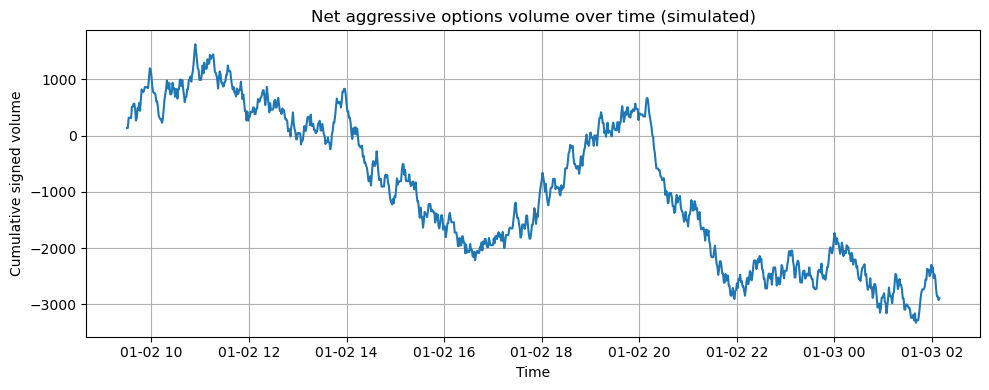

In [11]:

import matplotlib.pyplot as plt

signed_volume = np.where(trades["aggressor"] == "buyer",
                         trades["volume"],
                         np.where(trades["aggressor"] == "seller",
                                  -trades["volume"],
                                  0))
trades["signed_volume"] = signed_volume
trades["cum_signed_volume"] = trades["signed_volume"].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(trades["timestamp"], trades["cum_signed_volume"])
plt.xlabel("Time")
plt.ylabel("Cumulative signed volume")
plt.title("Net aggressive options volume over time (simulated)")
plt.grid(True)
plt.tight_layout()
plt.show()


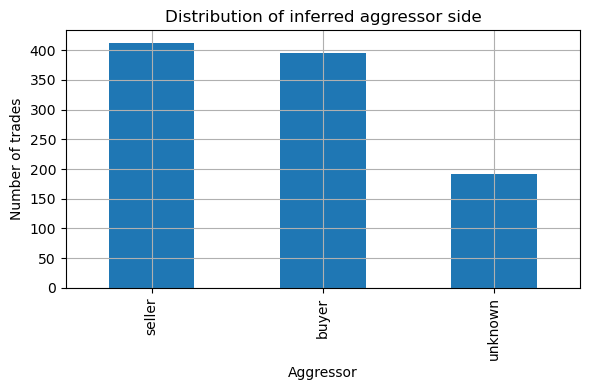

In [12]:

# Bar plot of aggressor counts
counts = trades["aggressor"].value_counts()

plt.figure(figsize=(6, 4))
counts.plot(kind="bar")
plt.xlabel("Aggressor")
plt.ylabel("Number of trades")
plt.title("Distribution of inferred aggressor side")
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. Interpretation and limitations
The simulated results tend to show a reasonably balanced mix of buyer‑ and seller‑initiated trades, with some portion classified as unknown because trades occur near the midpoint. Opening trades often dominate when open interest changes significantly, while mixed trades capture cases where volume and open interest move in the same direction but with small net effect.

From a methodological perspective, this exercise illustrates how relatively simple quote‑based rules can yield informative labels for aggressor side and position type. In practice, however, several limitations are important:

- Real options markets exhibit more complex microstructure, including hidden liquidity, auctions, and complex order types
- Data quality issues such as out‑of‑sequence prints, crossed markets, and stale quotes can distort classification
- The mapping from inferred aggressor to informed trading is indirect; a buyer‑initiated trade is not necessarily informed trading

Nevertheless, similar techniques underpin many empirical studies of options order flow and are often used as building blocks for more sophisticated models, including those that attempt to detect informed trading or to link options activity to subsequent movements in the underlying asset.

## 9. Possible extensions
Several natural extensions suggest themselves:

- Apply the same classification to real options data from a vendor or exchange feed
- Incorporate implied volatility and delta to study whether aggressive trades cluster in particular regions of the volatility surface
- Combine this framework with event studies around earnings announcements or macroeconomic releases

Such developments would bring the analysis closer to current empirical research in options markets and market microstructure.